In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


# Objective Function

We desire to create and objective function to compare remote sensing systems.  Important properties of this objective function are:
- Area collection rate
- Incorporates data or image quality including:
    - Spectral Resolution
    - Spatial Resolution
    - Geometric image quality (MTF, RER, etc)
    - Signal to noise or equivalent (NE$\Delta \rho$, etc)
    
Our objective function thus has the form:

$$ V = \dot{A} \sum_{i} a(\lambda^c_i, \Delta \lambda_i)Q_i^\alpha$$

where $\dot{A}$ is simply the area collection rate in something like sq.km / day, $Q$ is the data quality metric, $a$ is a spectral value weight and $\alpha$ scales quality.

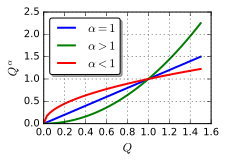

In [2]:
Q = linspace(0, 1.5)
plt.figure(figsize=(3,2))
plt.plot(Q, Q, label=r'$\alpha=1$')
plt.plot(Q, Q**2, label=r'$\alpha>1$')
plt.plot(Q, Q**0.5, label=r'$\alpha<1$')
plt.xlabel(r'$Q$')
plt.ylabel(r'$Q^\alpha$')
plt.legend(loc='best')

## Data / Image quality
Image quality can be quantified to first order by:
- Sampling resolution (GSD)
- Optical "sharpness" (MTF or RER)
- Signal-to-noise ratio or equivalent metric

Since much work has already been performed in this area, we will defer to the Generalized Image Quality Equation (GIQE) to provide a single image quality metric.  The GIQE5 is defined as:

$$ NIIRS = c_0 + c_1 \log{(GSD)} + c_2\left[1 - e^{c_3 / \Delta SNR}\right] \log{(RER_0)} + c_4 \log{(RER_0)}^4 + \frac{c_5}{\Delta SNR} + \frac{c_6}{px_{smear}} $$

Because we want to consider systems with a wide variety of spectral bands, we will normalize $GSD$ by $\lambda^c_i$.  The justification for this is to not penalize systems that are designed for longer wavelengths and thus limited by diffraction.  Note that GIQE5 is nominally for the visible spectrum and because it is not non-dimensional we need to normalize $\lambda^c_i$ by the center of the visible band to preserve its behavior.  So our quality metric becomes:

$$Q_i = c_0 + c_1 \log{\left(\frac{GSD}{\lambda^c_i / 550\text{nm}}\right)} + c_2\left[1 - e^{c_3 / \Delta SNR}\right] \log{(RER_0)} + c_4 \log{(RER_0)}^4 + \frac{c_5}{\Delta SNR} + \frac{c_6}{px_{smear}}$$

Note that in GIQE5 $c_0$ is a simple constant (4.4) that is set based on the NIIRS scale.  It comes from the fact that a reasonable quality (RER, SNR) 1m GSD system has a NIIRS of approximately 4.5.  We would like to consider systems with a range of spectrum-normalized GSD's out to 100m so we will set our $c_0$ to 7. The dependence of $Q_i$ on GSD and $\lambda^c_i$ is plotted below:

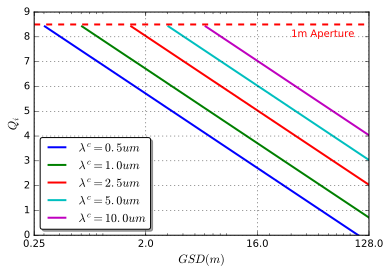

In [3]:
def Q_i(GSD, SNR, RER0, smear, lambda_c):
    c = [7, -3.32, 3.32, -5.308, -0.402, -2.92, -0.069]
    return c[0] + c[1]*np.log10(GSD*550e-9/lambda_c) + c[2]*(1. - np.exp(c[3]/SNR)) * log10(RER0) + \
            c[4]*log10(RER0)**4 + c[5]/SNR + c[6]*smear

for lambda_c in [500e-9, 1e-6, 2.5e-6, 5e-6, 10e-6]:
    GSD_v = linspace(max(0.25,1.22 * lambda_c * 500e3), 128)
    plt.semilogx(GSD_v, Q_i(GSD_v, 100, 0.5, 1., lambda_c),basex=2,
                 label=r'$\lambda^c = %.1f um$' % (lambda_c * 1e6))
plt.semilogx([0.25, 128], [8.5, 8.5], 'r--')
plt.text(30, 8, '1m Aperture', fontdict={'color' : 'r'})
plt.xlim(0.25, 128)
plt.xticks(logspace(-2, 7, 4, base=2), logspace(-2, 7, 4, base=2))
plt.ylim(0, 9)
plt.ylabel(r'$Q_i$')
plt.xlabel(r'$GSD(m)$')
plt.legend(loc='best')

## Spectral weighting

Depending on phenomenon, spectral sampling in the data has different value.  We will use a function $a(\lambda^c_i, \Delta \lambda_i)$ that weighs a given band by both its center wavelength and bandwidth.  Note that there are many possible ways to chose $a$ and that we will pick one that we believe gives intuitive results.

## Chosing $\alpha$

$\alpha$ is an important parameter as it dictates how important image quality becomes in the objective function.  Just as with $a$ there are many possible ways to chose $\alpha$.  

### Case 1: $\alpha = 1$
The most straightforward is $\alpha=1$ giving a linear dependence between GIQE5 image quality and value.  This would imply that while clean in many ways, the reality is that the existing market for remote sensing data does not follow this.  

In [4]:
logspace(-2, 7, 4, base=2)

array([   0.25,    2.  ,   16.  ,  128.  ])